#### Buy decision
- if 10-period RSI of the stock is below 30
    - Buy on the next day's open
    
#### Sell decision
- if 10-period RSI is above 40 OR after 10 trading days
    - Sell on next days open

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import backtrader as bt
import datetime
pd.options.mode.chained_assignment = None

import matplotlib

In [3]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers['Symbol'].to_list()
tickers = [i.replace('.', '-') for i in tickers]

In [4]:
# Errors
tickers.pop(474)
tickers.pop(489)

'WU'

In [5]:
def RSIcalc(ticker):
    df = yf.download(ticker, start='2011-01-1')
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()
    df['price change'] = df['Adj Close'].pct_change()
    df['Upmove'] = df['price change'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['price change'].apply(lambda x: abs(x) if x < 0 else 0)
    df['avg up'] = df['Upmove'].ewm(span=19).mean()
    df['avg down'] = df['Downmove'].ewm(span=19).mean()
    df = df.dropna()
    df['RS'] = df['avg up'] / df['avg down']
    df['RSI'] = df['RS'].apply(lambda x: 100 - (100/(x+1)))
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI'] < 30), 'Buy'] = '1'
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI'] > 30), 'Buy'] = '0'
    return df

In [6]:
df = RSIcalc(tickers[0])
df['Buy'] = pd.to_numeric(df['Buy'])

[*********************100%***********************]  1 of 1 completed


In [7]:
from backtrader.feeds import PandasData

class PandasDivergence(PandasData):
    lines = ('Adj Close', 'MA200',
       'price change', 'Upmove', 'Downmove', 'avg up', 'avg down', 'RS', 'RSI',
       'Buy')

    # add the parameter to the parameters inherited from the base class
    #  -1 : autodetect position or case-wise equal name
    #  string : column name (as index) in the pandas dataframe
    params = (('Adj Close', -1),
              ('MA200', -1),
              ('price change', -1),
              ('Upmove', -1),
             ('Downmove', -1),
             ('avg up', -1),
             ('avg down', -1),
             ('RS', -1),
             ('RSI', -1),
             ('Buy', -1))

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,MA200,price change,Upmove,Downmove,avg up,avg down,RS,RSI,Buy
Date,,,,,,,,,,,,,,,
2011-10-14,78.940002,79.230003,78.120003,78.889999,60.409805,2840800,67.103449,0.014011,0.014011,0.000000,0.011144,0.006978,1.596943,61.493185,0
2011-10-17,78.629997,79.050003,75.660004,75.879997,58.104897,4359500,67.069641,-0.038155,0.000000,0.038155,0.010029,0.010096,0.993422,49.835013,0
2011-10-18,76.180000,79.150002,75.709999,78.360001,60.003960,4167200,67.043486,0.032683,0.032683,0.000000,0.012295,0.009086,1.353122,57.503273,0
2011-10-19,78.260002,78.860001,77.269997,77.699997,59.498554,3865000,67.015254,-0.008423,0.000000,0.008423,0.011065,0.009020,1.226767,55.091845,0
2011-10-20,77.769997,79.059998,77.110001,78.680000,60.248985,4087300,66.990775,0.012613,0.012613,0.000000,0.011220,0.008118,1.382134,58.020832,0


In [17]:
class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datarsi = self.datas[0].RSI
        self.databuy= self.datas[0].Buy
        self.date = self.datas[0].datetime.date()
        #self.buydate, self.selldate = getSignals(self.datas[0])
        pass

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def next(self):
        # If DF['Buy'] = 1: Buy
        # If 10 days pass OR df['RSI'][start + current] > 40: Sell
        current_date = self.datas[0].datetime.date()
        if self.databuy[0] and not self.position:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.order = self.buy()
            self.buy_date = self.datas[0].datetime.date()
            self.buy_rsi = self.datarsi
            return
        else:
            # Currently selling after 10 days
            if self.position:
                if (((current_date - self.buy_date) >= datetime.timedelta(days=20)) 
                or (self.datarsi[0] > 40)):
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()
                    return
        
        

In [18]:
cerebro = bt.Cerebro()
cerebro = bt.Cerebro(stdstats=False)
cerebro.addstrategy(TestStrategy)

data = PandasDivergence(dataname=df)

cerebro.adddata(data)

cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.PercentSizer)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run(stdstats=False)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2012-03-06, BUY CREATE, 84.95
2012-03-07, BUY EXECUTED, 85.24
2012-03-08, SELL CREATE, 86.71
2012-03-09, SELL EXECUTED, 86.81
2012-04-10, BUY CREATE, 84.58
2012-04-11, BUY EXECUTED, 85.36
2012-04-12, SELL CREATE, 86.86
2012-04-13, SELL EXECUTED, 86.49
2012-05-14, BUY CREATE, 85.83
2012-05-15, BUY EXECUTED, 85.95
2012-05-23, SELL CREATE, 84.80
2012-05-24, SELL EXECUTED, 84.96
2012-06-04, BUY CREATE, 82.62
2012-06-05, BUY EXECUTED, 82.59
2012-06-06, SELL CREATE, 84.63
2012-06-07, SELL EXECUTED, 85.59
2012-10-23, BUY CREATE, 88.73
2012-10-24, BUY EXECUTED, 89.03
2012-11-05, SELL CREATE, 89.60
2012-11-06, SELL EXECUTED, 89.95
2013-08-21, BUY CREATE, 113.42
2013-08-22, BUY EXECUTED, 113.61
2013-08-22, SELL CREATE, 114.67
2013-08-23, SELL EXECUTED, 114.76
2014-01-24, BUY CREATE, 130.22
2014-01-27, BUY EXECUTED, 130.02
2014-02-06, SELL CREATE, 128.90
2014-02-07, SELL EXECUTED, 129.57
2014-07-31, BUY CREATE, 140.89
2014-08-01, BUY EXECUTED, 140.15
2014-08-08,

<IPython.core.display.Javascript object>


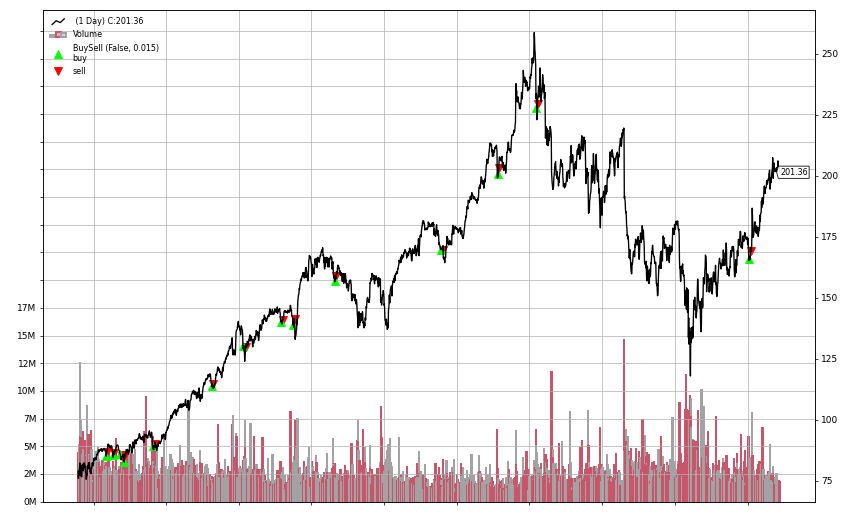

[[<Figure size 432x288 with 2 Axes>]]

In [19]:
cerebro.plot()